In [17]:
from dotenv import load_dotenv

load_dotenv()  # loads variables from .env into environment

True

In [18]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

In [19]:
import getpass
import os

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.0-flash-001", model_provider="google_genai")

In [20]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.llm import LLMChain
from langchain_core.prompts import ChatPromptTemplate

# Define prompt
prompt = ChatPromptTemplate.from_messages(
    [("human", "Write a concise summary of the following:\\n\\n{context}")]
)

# Instantiate chain
chain = create_stuff_documents_chain(llm, prompt)

# Invoke chain
result = chain.invoke({"context": docs})
print(result)

This article discusses LLM-powered autonomous agents, systems that use large language models (LLMs) as the core controller, augmented with planning, memory, and tool use capabilities.

**Key Components:**

*   **Planning:** Agents decompose tasks into subgoals (Chain of Thought, Tree of Thoughts) and refine actions through self-reflection (ReAct, Reflexion, Chain of Hindsight, Algorithm Distillation).
*   **Memory:** Agents utilize short-term (in-context learning) and long-term memory (external vector stores with fast retrieval using algorithms like LSH, ANNOY, HNSW, FAISS, and ScaNN) to retain and recall information.
*   **Tool Use:** Agents learn to use external APIs (MRKL, Toolformer, ChatGPT Plugins, HuggingGPT, API-Bank) to access information and capabilities not present in the LLM itself.

**Case Studies:**

*   **Scientific Discovery Agent (ChemCrow):** Uses expert-designed tools for tasks in chemistry.
*   **Generative Agents:** Simulates believable human behavior in a sandbox 

In [21]:
for token in chain.stream({"context": docs}):
    print(token, end="|")

This| blog post explores the concept of LLM-powered autonomous agents, positioning LLMs as the| "brain" of the agent. The core components include:

1.  **Planning|:** Breaking down tasks into subgoals (Task Decomposition) using techniques like Chain of Thought (CoT) and Tree of Thoughts (ToT), and incorporating Self|-Reflection to learn from past actions (e.g., ReAct, Reflexion, Chain of Hindsight, Algorithm Distillation).

2.  **Memory:** Utilizing| short-term memory (in-context learning) and long-term memory (external vector stores with fast retrieval using MIPS algorithms like LSH, ANNOY, HNSW, FAISS, and ScaNN).

3.|  **Tool Use:** Enabling agents to access external APIs for information and capabilities not directly within the LLM (e.g., MRKL, TALM, Toolformer, ChatGPT Plugins, HuggingGPT, API-Bank).

The post also| presents case studies, including a Scientific Discovery Agent (ChemCrow) and Generative Agents Simulation, and discusses proof-of-concept examples like AutoGPT and GPT-

In [22]:
from langchain_core.prompts import ChatPromptTemplate

map_prompt = ChatPromptTemplate.from_messages(
    [("human", "Write a concise summary of the following:\\n\\n{context}")]
)

In [23]:
# Also available via the hub: `hub.pull("rlm/reduce-prompt")`
reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary
of the main themes.
"""

reduce_prompt = ChatPromptTemplate([("human", reduce_template)])

In [24]:
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
split_docs = text_splitter.split_documents(docs)
print(f"Generated {len(split_docs)} documents.")

Created a chunk of size 1003, which is longer than the specified 1000


Generated 13 documents.


In [25]:
import operator
from typing import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

token_max = 1000


def length_function(documents: List[Document]) -> int:
    """Get number of tokens for input contents."""
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)


# This will be the overall state of the main graph.
# It will contain the input document contents, corresponding
# summaries, and a final summary.
class OverallState(TypedDict):
    # Notice here we use the operator.add
    # This is because we want combine all the summaries we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]
    final_summary: str


# This will be the state of the node that we will "map" all
# documents to in order to generate summaries
class SummaryState(TypedDict):
    content: str


# Here we generate a summary, given a document
async def generate_summary(state: SummaryState):
    prompt = map_prompt.invoke(state["content"])
    response = await llm.ainvoke(prompt)
    return {"summaries": [response.content]}


# Here we define the logic to map out over the documents
# We will use this an edge in the graph
def map_summaries(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]


def collect_summaries(state: OverallState):
    return {
        "collapsed_summaries": [Document(summary) for summary in state["summaries"]]
    }


async def _reduce(input: dict) -> str:
    prompt = reduce_prompt.invoke(input)
    response = await llm.ainvoke(prompt)
    return response.content


# Add node to collapse summaries
async def collapse_summaries(state: OverallState):
    doc_lists = split_list_of_docs(
        state["collapsed_summaries"], length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(await acollapse_docs(doc_list, _reduce))

    return {"collapsed_summaries": results}


# This represents a conditional edge in the graph that determines
# if we should collapse the summaries or not
def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state["collapsed_summaries"])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"


# Here we will generate the final summary
async def generate_final_summary(state: OverallState):
    response = await _reduce(state["collapsed_summaries"])
    return {"final_summary": response}


# Construct the graph
# Nodes:
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_node("generate_final_summary", generate_final_summary)

# Edges:
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

app = graph.compile()

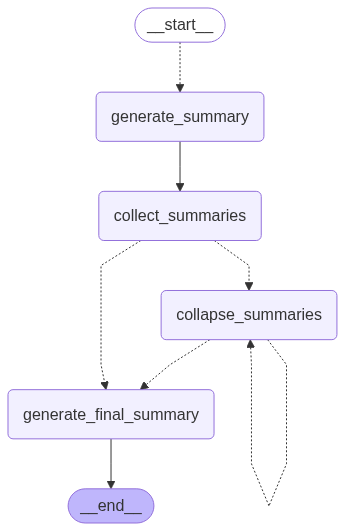

In [26]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [27]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in split_docs]},
    {"recursion_limit": 10},
):
    print(list(step.keys()))

['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['collect_summaries']
['collapse_summaries']
['generate_final_summary']


In [28]:
print(step)

{'generate_final_summary': {'final_summary': 'Large Language Models (LLMs) are being developed as autonomous agents capable of complex problem-solving, driven by planning, memory, and tool use. Planning involves breaking down tasks and self-reflection for iterative improvement. Memory mirrors human memory, utilizing both short-term (in-context learning) and long-term (external vector stores) capabilities. Tool use allows LLMs to access external APIs and specialized modules, extending their functionality. These agents are being applied to various tasks, including web browsing, file manipulation, code generation, and even social simulation, with AutoGPT and GPT-Engineer as examples. However, challenges remain including finite context length, difficulties in long-term planning, unreliable natural language interfaces, and ethical concerns about potential misuse, such as generating synthesis plans for chemical weapons. Benchmarks like API-Bank are being developed to evaluate tool-augmented 